In [4]:
import os
import sys
import cv2
import filecmp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.abspath('../'))
from src.lib import features as ft
from src.lib import centroids as centutils

/home/juanjo/VirtualEnvs/Fondef/lib/python3.8/site-packages/skan/csr.py:21: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(csr_spec)


In [5]:
df_first_path = '../results/first_features.csv'
df_negsi_path = '../results/NegsiRNA_features.csv'
df_test_path = '../results/Test_features.csv'

df_first = pd.read_csv(df_first_path, index_col=0)
df_negsi = pd.read_csv(df_negsi_path, index_col=0)
df_test = pd.read_csv(df_test_path, index_col=0)

df_first = df_first.fillna(-1)
df_negsi = df_negsi.fillna(-1)
df_test = df_test.fillna(-1)

df_inter_first_negsi = df_first.merge(df_negsi, left_index=True, right_index=True)
df_inter_first_test = df_first.merge(df_test, left_index=True, right_index=True)
df_inter_negsi_test = df_negsi.merge(df_test, left_index=True, right_index=True)

df_test_no_intersection = df_test.drop(df_inter_first_test.index)

df_first['folder'] = 'first'
df_negsi['folder'] = 'NegsiRNA'
df_test_no_intersection['folder'] = 'Test'

df_all = pd.concat([df_first, df_negsi, df_test_no_intersection])
df_all

,cell_area_ratio,white_area_ratio,e2e_n,e2e_distance_mean,e2e_distance_std,e2e_eu_distance_mean,e2e_eu_distance_std,e2e_distance_ratio_mean,e2e_distance_ratio_std,j2e_n,...,nodes_std,medial_axis_mean,medial_axis_std,voronoi_approx_mean,voronoi_approx_std,std_filter_mean,std_filter_std,entropy_filter_mean,entropy_filter_std,folder
ACTB_B2_CA,0.603739,0.280296,8,11.673097,16.213742,10.770630,13.984421,0.970518,0.047607,361,...,0.344300,9.385630,6.708586,9.997991,6.821478,8.198705,5.645586,4.122258,0.566555,first
ACTN4_L3_NO,0.643184,0.264147,2,5.328427,0.707107,4.621320,0.535534,0.868272,0.014719,508,...,0.329785,7.979354,5.130908,8.927850,5.022501,5.150305,3.239704,3.679391,0.585222,first
ACTB_B2_NS,0.529037,0.393422,2,6.621320,4.535534,5.914214,4.363961,0.872069,0.061719,348,...,0.340088,13.342543,8.466754,14.887825,8.152079,8.104494,5.593832,4.099480,0.562513,first
NegsiRNA_B1_NO,0.584348,0.361675,3,2.276142,1.863171,2.179106,1.696244,0.978017,0.038075,414,...,0.359689,10.740390,6.388646,11.921827,6.126879,5.706624,3.521712,3.810957,0.542083,first
NegsiRNA_B1_CA,0.672008,0.249850,5,25.802439,24.656564,23.709567,23.061234,0.897672,0.111001,291,...,0.372899,9.099332,6.238017,9.655176,6.140472,5.103108,3.393098,3.680185,0.573167,first
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PALLD_F2_CA,0.532583,0.352931,1,13.000000,-1.000000,13.000000,-1.000000,1.000000,-1.000000,272,...,0.333959,10.779967,6.281335,11.602166,6.057167,7.477804,5.024334,4.046653,0.558139,Test
EZR_C3_NO,0.648874,0.290315,1,2.000000,-1.000000,2.000000,-1.000000,1.000000,-1.000000,312,...,0.344878,8.982927,5.137285,9.530259,4.744985,5.470714,3.365124,3.763924,0.556228,Test
DNMBP_A3_NO,0.603660,0.226212,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,411,...,0.350006,7.369823,4.892748,7.902959,4.893513,4.808559,2.676384,3.642820,0.560697,Test
NUMB_E3_CA,0.654215,0.271097,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,275,...,0.347745,8.482209,5.014825,9.041384,4.877564,4.326597,2.793765,3.543888,0.565170,Test


In [6]:
TEMPLATE_PATH = "../data/{folder}/{img_type}/{name}{suffix}.tif"
RESULTS_PATH = '../results/features'
TYPE_SUFFIX_MAP = {"Original": "j", "Nuclei": "n", 
                   "Skeletonized": "j-SK", "Segmented": "j-BI"}
IMG_SIZE = (256, 256)
SUBIMG_PADDING = 10 


In [7]:
def draw_lines(df, image, color, thickness=5):
    copy = image.copy()
    for _, row in df.iterrows():
        x0 = int(row['image-coord-src-0'])
        y0 = int(row['image-coord-src-1'])
        x1 = int(row['image-coord-dst-0'])
        y1 = int(row['image-coord-dst-1'])
        cv2.line(copy, (y0, x0), (y1, x1), color, thickness)
    return copy

In [10]:
def get_skeleton_branches_features_plot(df_all, feature_name):
    branch_to_number_map = {"e2e": 0, "j2e": 1, "j2j": 2}
    branch_to_colors_map = {
        "e2e": (255, 0, 0),
        "j2e": (0, 255, 0),
        "j2j": (0, 0, 255)    
    }
    branch_to_thickness_map = {"e2e": 30, "j2e": 10, "j2j": 10}
    ft_to_column = {
        "distance": "branch-distance",
        "eu_distance": "euclidean-distance",
        "distance_ratio": "distance-ratio"
    }

    ft_prefix = feature_name[:3]
    ft_number = branch_to_number_map[ft_prefix]
    ft_color = branch_to_colors_map[ft_prefix]
    ft_thickness = branch_to_thickness_map[ft_prefix]
    ft_type = ft_to_column['_'.join(feature_name.split("_")[1:-1])]

    df_sorted = df_all.sort_values(by=feature_name)
    fig, axes = plt.subplots(2, 10, figsize=(10*5, 2*5))
    
    for index, (img_name, row) in enumerate(df_sorted[:10].iterrows()):
        print(img_name)
        seg_path = TEMPLATE_PATH.format(folder=row['folder'], 
                                       img_type="Segmented", 
                                       name=img_name, 
                                       suffix="j-BI")
        sk_path = TEMPLATE_PATH.format(folder=row['folder'], 
                                       img_type="Skeletonized", 
                                       name=img_name, 
                                       suffix="j-SK")
        original_path = TEMPLATE_PATH.format(folder=row['folder'], 
                                            img_type="Original", 
                                            name=img_name, 
                                            suffix="j")
        
        seg_img = cv2.imread(seg_path)
        sk_img = cv2.imread(sk_path)
        original_img = cv2.imread(original_path)
        
        if seg_img.shape > original_img.shape:
            seg_img = centutils.clip_image(seg_img, original_img.shape[:2])

        if sk_img.shape > original_img.shape:
            sk_img = centutils.clip_image(sk_img, original_img.shape[:2])

        degrees, branch_data = ft.get_skeleton_data(sk_img)
        branch_data['distance-ratio'] = branch_data['euclidean-distance'] / branch_data['branch-distance']
        branch_data_slice = branch_data[branch_data['branch-type'] == ft_number]
        data_img = draw_lines(df=branch_data_slice,
                                image=seg_img,
                                color=ft_color,
                                thickness=ft_thickness)
        data_img = cv2.resize(data_img, IMG_SIZE)
        raw_data = branch_data_slice[ft_type]
        feature_name_no_stts = "_".join(feature_name.split("_")[:-1])
        prev_mean = row[feature_name_no_stts + '_mean']
        prev_std = row[feature_name_no_stts + '_std']
        new_mean = raw_data.mean()
        new_std = raw_data.std()

        assert abs(prev_mean - new_mean) < 1e-4
        assert abs(prev_std - new_std) < 1e-4
        
        label = '{img_name}: mean = {mean:.1f}, std = {std:.1f}'.format(
            img_name=img_name, mean=prev_mean, std=prev_std)
        
        iii, jjj = (2*index) // 10, (2*index) % 10
        axes[iii, jjj].imshow(data_img)
        raw_data.hist(bins=20, ax=axes[iii, jjj+1])


        axes[iii, jjj].set_yticks([])
        axes[iii, jjj].set_xticks([])

        axes[iii, jjj].set_xlabel(label, fontsize=20, horizontalalignment='left', x=0.3, labelpad=20)
        
    fig.suptitle('Segmented image with overlay skeleton, ordered by the feature {}'.format(feature_name), y=0.95, fontsize=30)
    return fig, axes


CD151_A3_NO
ACTN4_L2_NO
ADAM9_C2_NO
NegsiRNA_L3_NS
NegsiRNA_A3_NS
NegsiRNA_I2_CA
NegsiRNA_A3_NO
NegsiRNA_A3_CA
NegsiRNA_A2b_NO
AKT1_B2_CA


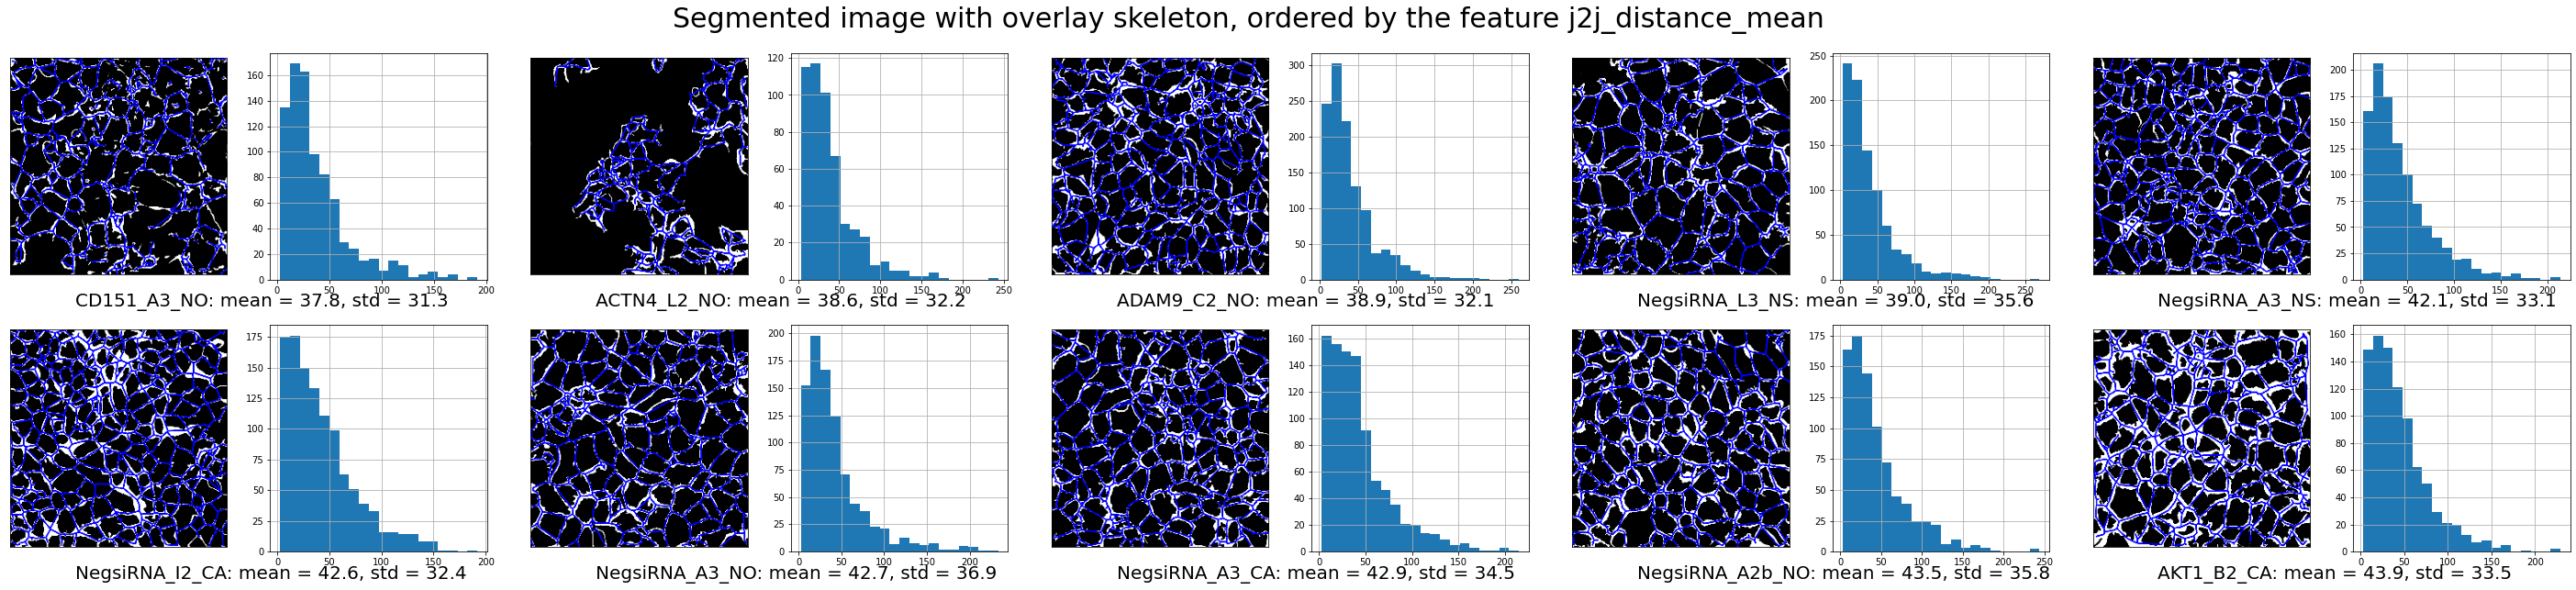

In [12]:
feature_name = 'j2j_distance_mean'
fig, axes = get_skeleton_branches_features_plot(df_all, feature_name)

In [16]:
img_name = 'CD151_A3_NO'
row = df_all.loc[img_name]
sk_path = TEMPLATE_PATH.format(folder=row['folder'], img_type="Skeletonized", 
                               name=img_name, suffix="j-SK")
sk_img = cv2.imread(sk_path)
degrees, branch_data = ft.get_skeleton_data(sk_img)

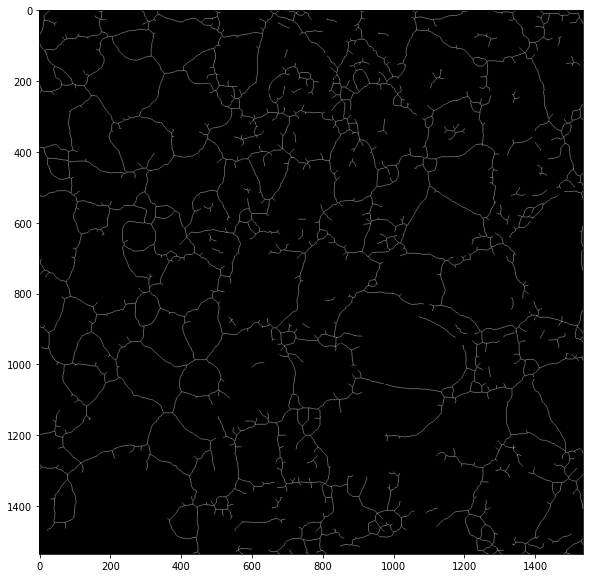

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(sk_img)

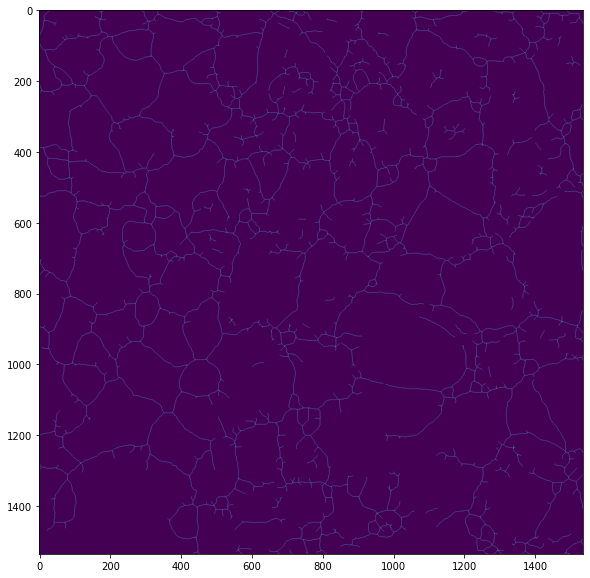

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(degrees)

In [24]:
nodes_coords = np.where(degrees > 2)

In [139]:
raw_data = pd.Series(degrees[np.where(degrees > 2)])
raw_data.mean()

3.1421588594704684

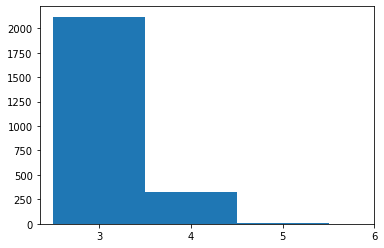

In [149]:
bins = np.arange(3, df_all['nodes_max'].max() + 1) - 0.5 
ax = raw_data.hist(bins=bins)
ax.set_xticks(np.arange(3, 7))
ax.grid(None)

In [132]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

len(nodes_coords[0])
sk_img_2 = sk_img.copy()
cmap = cm.YlOrRd
norm = Normalize(vmin=2, vmax=df_all['nodes_max'].max())

for x, y in zip(*nodes_coords):
    color = (255 * np.array(cmap(norm(degrees[x,y]))))[:-1]
    sk_img_2 = cv2.circle(sk_img_2, (y, x), radius=10, color=color, thickness=-1)
    

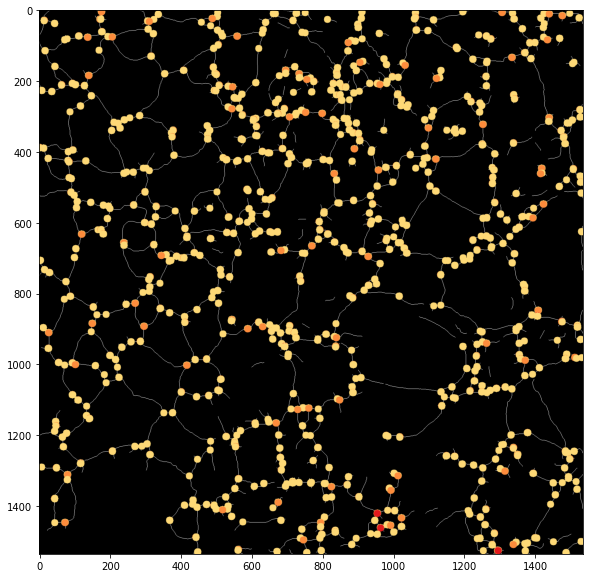

In [133]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
ax.imshow(sk_img_2)

In [56]:
sk_img_2.shape

(1536, 1536, 3)

In [117]:
dir(cm)

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'LUTSIZE',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'ScalarMappable',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_gen_cmap_d',
 '_reverser',
 'a

In [77]:
tuple((255*np.array(cmap(norm(3)))).astype(np.uint8))

(10, 0, 0, 255)